# Human Pose Estimation - Part 2

## Introduction to Convolutional Neural Networks - SVHN Image classifier

In [ ]:
# Download SVHN Dataset

# initialization
%matplotlib inline
import numpy as np
from PIL import Image
from scipy.io import loadmat
from matplotlib.pyplot import imshow, show

# download the train and teset datasets
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat
  
# Load the training data
train = loadmat('train_32x32.mat')
print("Training images dimensions: ", train['X'].shape) # Input Data
print("Training labels dimensions: ", train['y'].shape) # Labels

test = loadmat('test_32x32.mat')
print("Test images dimensions: ", test['X'].shape)
print("Test labels dimensions: ", test['y'].shape)

--2019-10-23 23:13:33--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat.6’

train_32x32.mat.6   100%[===================>] 173.61M  52.7MB/s    in 4.3s    

2019-10-23 23:13:37 (40.8 MB/s) - ‘train_32x32.mat.6’ saved [182040794/182040794]

--2019-10-23 23:13:38--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat.6’

test_32x32.mat.6    100%[===================>]  61.30M  30.0MB/s    in 2.0s    

2019-10-23 23:13:40 (30.0 MB/s) - ‘test_32x32.mat.6’ saved [642

In [ ]:
# Build our custom Dataset
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

class SVHN_dataset(Dataset):
    def __init__(self, data):
        # Transform data to Torch Tensors
        self.images = torch.tensor(data['X']).permute([3,2,0,1])
        self.labels = torch.tensor(data['y'])
        self.size = self.labels.shape[0]

        # replace label 10 with label 0
        self.labels[self.labels==10] = 0

        # normalize images to 0..1 range
        self.images = self.images.float()/255.0

        # print some information about the dataset      
        print("Label Dimensions: ", self.labels.shape)
        print("Image Dimensions: ", self.images.shape)
        
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]
      
        

In [ ]:
# Dataloader
train_dataloader = DataLoader(SVHN_dataset(train), batch_size=512,shuffle=True, num_workers=2)
test_dataloader = DataLoader(SVHN_dataset(test), batch_size=512,shuffle=False, num_workers=2)

Label Dimensions:  torch.Size([73257, 1])
Image Dimensions:  torch.Size([73257, 3, 32, 32])
Label Dimensions:  torch.Size([26032, 1])
Image Dimensions:  torch.Size([26032, 3, 32, 32])


In [ ]:
# Build CNN Architecture
# Expected accuracy: ~88%
class ConvClassifier(nn.Module):

    def __init__(self):
        super(ConvClassifier,self).__init__()
        #Convolution 1
        self.conv1=nn.Conv2d(in_channels=3,out_channels=6, kernel_size=5,stride=1, padding=2)
        nn.init.normal_(self.conv1.weight, std=0.001)
        nn.init.constant_(self.conv1.bias, 0)
        self.bn1 = nn.BatchNorm2d(6)
        self.relu1= nn.ReLU()
        self.maxpool1= nn.MaxPool2d(kernel_size=2,stride=2)

        #Convolution 2
        self.conv2=nn.Conv2d(in_channels=6,out_channels=12, kernel_size=3,stride=1, padding=1)
        nn.init.normal_(self.conv2.weight, std=0.001)
        nn.init.constant_(self.conv2.bias, 0)
        self.bn2 = nn.BatchNorm2d(12)
        self.relu2= nn.ReLU()
        self.maxpool2= nn.MaxPool2d(kernel_size=2,stride=2)
        
        #Convolution 3
        self.conv3=nn.Conv2d(in_channels=12,out_channels=24, kernel_size=3,stride=1, padding=1)
        nn.init.normal_(self.conv3.weight, std=0.001)
        nn.init.constant_(self.conv3.bias, 0)
        self.bn3 = nn.BatchNorm2d(24)
        self.relu3= nn.ReLU()
        self.maxpool3= nn.MaxPool2d(kernel_size=2,stride=2)
        
        ### fully connected layer
        self.fc_input_size = 24*4*4
        self.fc4 = nn.Linear(self.fc_input_size, 10)
        nn.init.normal_(self.fc4.weight, std=0.001)
        nn.init.constant_(self.fc4.bias, 0)
        
    def forward(self,x):
        # conv layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        
        # final layer
        x = x.view(-1, self.fc_input_size)
        x = self.fc4(x)
        return(x)

In [ ]:
# Function to calculate accuracy
def get_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to('cuda')
            labels = labels.squeeze().to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
 
    model.train()
    return 100 * correct / total
    

In [ ]:
# Build Training Loop

# create model instance
model_conv = ConvClassifier().to('cuda')
model_conv.train()

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Create the optimizer
LEARNING_RATE = 0.001
optimizer = torch.optim.Adam(model_conv.parameters(), lr=LEARNING_RATE)

# Construct the training loop
NUM_EPOCHS = 50

for j in range(NUM_EPOCHS):   
    for i_batch, [images,labels] in enumerate(train_dataloader):
        images = images.to('cuda')
        labels = labels.to('cuda')
        optimizer.zero_grad() # Clear out accumulated gradients
        output = model_conv(images) # forward pass
        loss = loss_fn(output, (labels.long()).squeeze()) # calculate loss
        loss.backward() # Compute gradients
        optimizer.step() # Update model parameters

    if j % 1 == 0:
        accucacy = get_accuracy(model_conv,test_dataloader)
        print("Epoch", j, "Training Loss: ", loss.item(), "Test Accuracy: ", accucacy) 

        


Epoch 0 Training Loss:  0.7184999585151672 Test Accuracy:  76.61339889366933
Epoch 1 Training Loss:  0.29304394125938416 Test Accuracy:  81.94913952059004
Epoch 2 Training Loss:  0.45561110973358154 Test Accuracy:  83.25522433927473
Epoch 3 Training Loss:  0.3482583165168762 Test Accuracy:  80.58927473878303
Epoch 4 Training Loss:  0.43878066539764404 Test Accuracy:  79.37922556853104
Epoch 5 Training Loss:  0.41502606868743896 Test Accuracy:  84.76490473263675
Epoch 6 Training Loss:  0.28234079480171204 Test Accuracy:  86.36293792255685
Epoch 7 Training Loss:  0.28942573070526123 Test Accuracy:  85.04148740012293
Epoch 8 Training Loss:  0.31419554352760315 Test Accuracy:  86.9199446834665
Epoch 9 Training Loss:  0.27660244703292847 Test Accuracy:  87.24262446220037
Epoch 10 Training Loss:  0.3491206765174866 Test Accuracy:  86.8700061462815
Epoch 11 Training Loss:  0.7565778493881226 Test Accuracy:  86.6279963122311
Epoch 12 Training Loss:  0.24152295291423798 Test Accuracy:  87.58835

True Label:  5  Predicted Label:  5


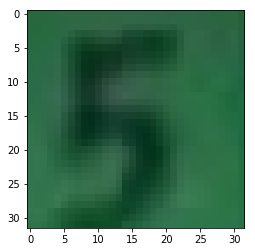

-------------
True Label:  2  Predicted Label:  2


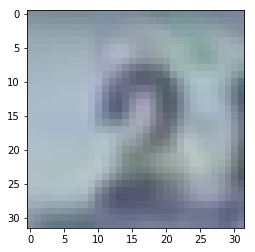

-------------
True Label:  1  Predicted Label:  1


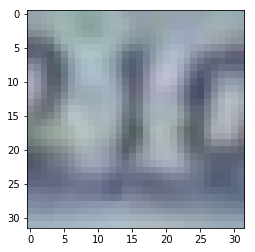

-------------
True Label:  0  Predicted Label:  0


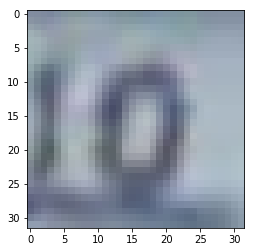

-------------
True Label:  6  Predicted Label:  6


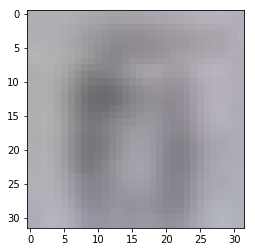

-------------


In [ ]:
# Run Inference

# evaluate the model on an example batch
images,labels = next(iter(test_dataloader))
images = images.to('cuda')
labels = labels.to('cuda')
model_conv.eval()
with torch.no_grad():
  outputs = model_conv(images)

# Display Result
num_samples = 10
train_size = train['X'].shape[0]
for i in range(5):
    im = images[i].cpu().permute(1,2,0).numpy()
    lbl = labels[i].cpu().numpy().squeeze()
    _,pred = torch.max(outputs[i],0)
    pred = pred.cpu().numpy()
    
    print("True Label: ", lbl, " Predicted Label: ",pred  )
    imshow(im)
    show()
    print("-------------")